In [1]:
import pickle as pkl
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pyeasyfi.data.load_data import get_data_from_cb
from pyeasyfi.utils.utils import  get_top_n_cryptos
from pyeasyfi.utils.fin import compute_log_returns, compute_returns
from pyeasyfi.risks.asset.volatility import compute_historical_volatility, compute_GARCH_volatility
from pyeasyfi.risks.asset.value_at_risk import compute_historical_VaR, compute_var_covar_VaR, compute_montecarlo_VaR
from pyeasyfi.risks.portfolio.volatility import compute_portfolio_historical_volatility
from pyeasyfi.risks.portfolio.value_at_risk import compute_portfolio_VaR
from pyeasyfi.utils.simulation_kernels.random_walk import RandomWalkSimulation


In [2]:
"""
crypto_list = get_top_n_cryptos(8)
data = get_data_from_cb(crypto_list, start_date='2021-06-01-00-00', end_date='2024-07-01-00-00', granularity=3600)
data.to_parquet("./historical_data.parquet")
data
"""

'\ncrypto_list = get_top_n_cryptos(8)\ndata = get_data_from_cb(crypto_list, start_date=\'2021-06-01-00-00\', end_date=\'2024-07-01-00-00\', granularity=3600)\ndata.to_parquet("./historical_data.parquet")\ndata\n'

In [3]:
data = pd.read_parquet("historical_data.parquet")


# We separate Cryptos

In [4]:
cryptos = set(data["crypto"])
data_dict = dict()

for crypto in cryptos : 
    data_dict[crypto] = data[data["crypto"] == crypto]

In [5]:
data_dict["BTC"]

,low,high,open,close,volume,crypto
time,,,,,,
2021-06-01 00:00:00,37140.92,37918.97,37276.23,37849.85,1382.050493,BTC
2021-06-01 01:00:00,37170.07,37831.06,37831.06,37200.52,632.492777,BTC
2021-06-01 02:00:00,36636.47,37300.00,37200.52,36860.57,647.014915,BTC
2021-06-01 03:00:00,36500.00,37139.33,36856.82,36714.69,555.584683,BTC
2021-06-01 04:00:00,36572.97,36956.48,36714.69,36753.45,331.339400,BTC
...,...,...,...,...,...,...
2024-06-30 20:00:00,61876.55,62300.00,61926.69,61888.93,277.524789,BTC
2024-06-30 21:00:00,61728.10,61921.79,61886.94,61828.03,123.826867,BTC
2024-06-30 22:00:00,61821.87,62850.00,61828.03,62793.77,679.187125,BTC


# Risk computation

## Compute volatility

In [6]:
# Historical Volatility
log_returns_dict = dict()
for key, value in data_dict.items() :
    log_returns_dict[key] = compute_returns(value["close"])
    volatility = compute_historical_volatility(log_returns_dict[key])
    print(f"Volatility for {key} : {volatility}")


Volatility for ETH : 71.98369896524991
Volatility for BTC : 58.36817390003322
Volatility for SOL : 109.41227706256099
Volatility for DOGE : 97.414532995286
Volatility for USDT : 0.7052783149265682
Volatility for XRP : 57.23807958604922


In [7]:
# ARCH Volatility
arch_log_returns_dict = dict()
for key, value in data_dict.items() :
    arch_log_returns_dict[key] = compute_returns(value["close"])
    volatility, model = compute_GARCH_volatility(arch_log_returns_dict[key]) # Auto manage rescaling
    print(f"Volatility for {key} : {volatility}")

Optimization terminated successfully    (Exit mode 0)
            Current function value: 3023.986085182251
            Iterations: 18
            Function evaluations: 105
            Gradient evaluations: 18
Volatility for ETH : 55.081206536763
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2816.624967475016
            Iterations: 14
            Function evaluations: 81
            Gradient evaluations: 14
Volatility for BTC : 48.249073688652686
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3445.3360732690726
            Iterations: 10
            Function evaluations: 59
            Gradient evaluations: 10
Volatility for SOL : 95.75520362961842
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3337.847406518494
            Iterations: 8
            Function evaluations: 47
            Gradient evaluations: 8
Volatility for DOGE : 75.87977698559209
Optimiza

/home/jean-marc/anaconda3/envs/streamlit/lib/python3.10/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001362. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


## Test Random Walk MonteCarlo simulation

In [8]:
list(data_dict["DOGE"]['close'])[-1]

0.12473

#### On Log returns

In [9]:
returns = compute_log_returns(data_dict["DOGE"]["close"])
simulator  = RandomWalkSimulation(returns, list(data_dict["DOGE"]['close'])[-1])
sim_results = simulator.run(150)
sim_results

,sim_1,sim_2,sim_3,sim_4,sim_5,sim_6,sim_7,sim_8,sim_9,sim_10,...,sim_141,sim_142,sim_143,sim_144,sim_145,sim_146,sim_147,sim_148,sim_149,sim_150
0,0.123932,0.120419,0.124342,0.115703,0.123281,0.122439,0.127713,0.128198,0.109942,0.127120,...,0.131449,0.121122,0.125514,0.120450,0.107839,0.125202,0.119329,0.134774,0.118140,0.120436
1,0.106790,0.125753,0.122406,0.109426,0.127154,0.115596,0.111264,0.126814,0.103855,0.110740,...,0.126195,0.127539,0.112835,0.119087,0.111726,0.121890,0.109632,0.132352,0.123483,0.118509
2,0.105280,0.133592,0.122242,0.109257,0.128068,0.111731,0.122728,0.115733,0.105045,0.112724,...,0.125698,0.125770,0.108260,0.113019,0.111087,0.135217,0.114172,0.131202,0.137704,0.119769
3,0.108163,0.137484,0.123722,0.114885,0.122841,0.114034,0.122761,0.117562,0.110786,0.112514,...,0.121532,0.123871,0.106349,0.108747,0.108399,0.129106,0.116688,0.133738,0.138093,0.131957
4,0.098933,0.132626,0.130031,0.117824,0.129905,0.113236,0.112453,0.129055,0.102715,0.108938,...,0.119356,0.116377,0.103336,0.102638,0.100506,0.118430,0.111034,0.135520,0.128264,0.131690
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,0.012242,0.138159,0.074955,0.167435,0.018748,0.166734,0.032056,0.021597,0.021907,0.064609,...,0.228308,0.148872,0.028051,0.166767,0.024843,0.310504,0.050202,0.028852,0.325877,0.035558
361,0.012516,0.140930,0.076997,0.151606,0.018363,0.175652,0.030269,0.023457,0.020827,0.062401,...,0.241868,0.150604,0.027802,0.160547,0.024183,0.318439,0.051060,0.027868,0.356449,0.038215
362,0.011742,0.144007,0.079753,0.154952,0.017861,0.187769,0.031501,0.024507,0.021453,0.062314,...,0.242374,0.138765,0.029860,0.146457,0.024189,0.318709,0.046899,0.028812,0.374474,0.040214
363,0.012295,0.139537,0.076237,0.156466,0.016501,0.179579,0.030468,0.026131,0.019896,0.060243,...,0.248631,0.134871,0.030727,0.143384,0.024610,0.325986,0.047845,0.029139,0.371253,0.041724


<Axes: >

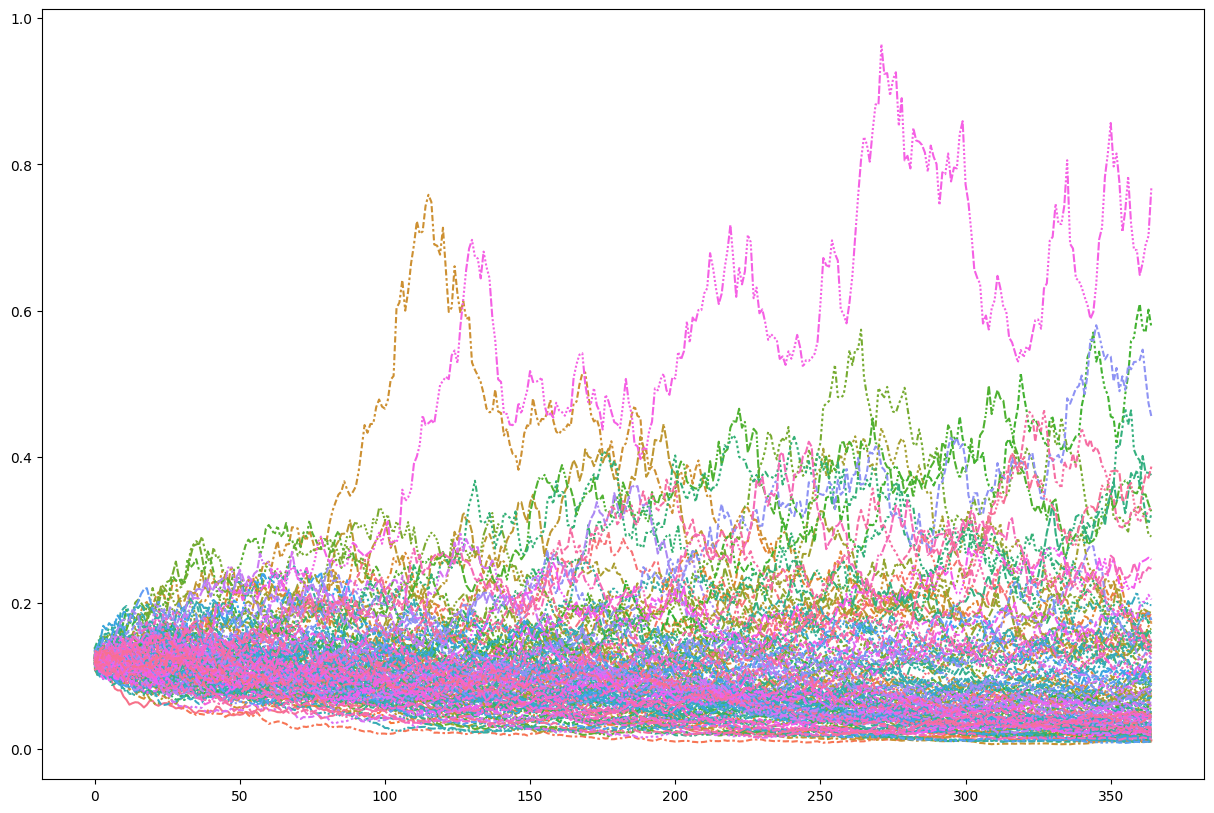

In [10]:
plt.figure(figsize=(15,10))
sns.lineplot(sim_results, legend=False)

#### On returns

In [11]:
"""returns = compute_returns(data_dict["DOGE"]["close"])
simulator  = RandomWalkSimulation(returns, list(data_dict["DOGE"]['close'])[-1]) #shouldn't use on normal returns
sim_results = simulator.run(150)
sim_results"""

'returns = compute_returns(data_dict["DOGE"]["close"])\nsimulator  = RandomWalkSimulation(returns, list(data_dict["DOGE"][\'close\'])[-1]) #shouldn\'t use on normal returns\nsim_results = simulator.run(150)\nsim_results'

In [12]:
"""plt.figure(figsize=(15,10))
sns.lineplot(sim_results, legend=False)"""

'plt.figure(figsize=(15,10))\nsns.lineplot(sim_results, legend=False)'

## Compute Value At Risk

In [13]:
# Historical VaR
returns_dict = dict()
for key, value in data_dict.items() :
    log_returns_dict[key] = compute_returns(value["close"])
    var = compute_historical_VaR(log_returns_dict[key])
    print(f"Value at risk for {key} : {var}")

Value at risk for ETH : -6.161158608918638
Value at risk for BTC : -4.720670457190191
Value at risk for SOL : -8.28361922220767
Value at risk for DOGE : -7.278290647656764
Value at risk for USDT : -0.042004725815977806
Value at risk for XRP : -4.524782378479985


In [14]:
# Variance covariance VAR
returns_dict = dict()
for key, value in data_dict.items() :
    log_returns_dict[key] = compute_returns(value["close"])
    var = compute_var_covar_VaR(log_returns_dict[key])
    print(f"Value at risk for {key} : {var}")

Value at risk for ETH : -118.30783602514522
Value at risk for BTC : -95.91252933049365
Value at risk for SOL : -179.68274920758935
Value at risk for DOGE : -160.20847895103321
Value at risk for USDT : -1.1601865577292263
Value at risk for XRP : -94.25643945890185


In [15]:
# Variance covariance VAR --> this is 95 annual loss en pct
returns_dict = dict()
for key, value in data_dict.items() :
    log_returns_dict[key] = compute_log_returns(value["close"])
    var = compute_montecarlo_VaR(log_returns_dict[key], start_price=value['close'][-1], n_simulations=100000, horizon=365)
    print(f"Value at risk for {key} : {var}")

Value at risk for ETH : -74.24837414991516
Value at risk for BTC : -61.763990354964385
Value at risk for SOL : -86.31857006375901
Value at risk for DOGE : -91.1472858091077
Value at risk for USDT : -1.1933431385927216
Value at risk for XRP : -81.15509061605248


# Compute Portfolio Risk

In [16]:
assets_df = pd.DataFrame()
for key, value in data_dict.items():
    assets_df[f"{key}"] = value["close"]
assets_df = assets_df.dropna()
#assets_df.index = assets_df["time"]
#assets_df = assets_df[list(data_dict.keys())]
#assets_df

In [17]:
log_ret = compute_log_returns(assets_df, return_pandas=True)
log_ret

,ETH,BTC,SOL,DOGE,USDT,XRP
0,-0.033992,-0.036938,0.025414,-0.027782,0.000120,-0.129191
1,-0.003622,-0.000952,0.028431,0.048992,-0.000250,-0.005022
2,-0.004420,-0.001784,-0.001457,-0.033638,0.000210,0.044452
3,-0.006259,-0.003463,-0.022862,0.004303,-0.000330,-0.013197
4,-0.007172,-0.009371,-0.047746,-0.017178,0.000020,0.054089
...,...,...,...,...,...,...
349,0.022384,0.013048,0.089228,0.033980,-0.000801,0.011228
350,-0.021106,-0.021358,-0.067307,-0.032677,-0.000501,-0.008250
351,-0.000107,0.009444,0.001787,-0.009242,0.000321,0.002334
352,0.017371,0.028857,0.044495,0.020817,-0.000040,0.007179


In [18]:
ret_df = compute_returns(assets_df, return_pandas=True)
ret_df

,ETH,BTC,SOL,DOGE,USDT,XRP
time,,,,,,
2023-07-14,-3.342057,-3.626449,2.573953,-2.739920,0.011995,-12.119359
2023-07-15,-0.361543,-0.095185,2.883895,5.021165,-0.024987,-0.500974
2023-07-16,-0.441017,-0.178241,-0.145613,-3.307853,0.020994,4.545455
2023-07-17,-0.623902,-0.345680,-2.260299,0.431220,-0.032984,-1.311037
2023-07-18,-0.714667,-0.932718,-4.662439,-1.703163,0.002000,5.557815
...,...,...,...,...,...,...
2024-06-27,2.263668,1.313307,9.332943,3.456428,-0.080052,1.129101
2024-06-28,-2.088473,-2.113173,-6.509232,-3.214877,-0.050073,-0.821572
2024-06-29,-0.010671,0.948911,0.178891,-0.919971,0.032063,0.233645


### Same Weight ptf

In [19]:
nb_cryptos = len(data_dict.keys())
weights = [1/nb_cryptos] * nb_cryptos

In [20]:
compute_portfolio_historical_volatility(ret_df, weights)

112.69405665209587

In [ ]:
compute_portfolio_VaR(ret_df, weights)